# Overview

Finally, as a follow on from our Unsupervised Clustering, we will again attempt to split the atom. This chain reaction of goodness cannot be stopped. We are on our way to meltdown (in a positive way). 

Since the unsupervised clustering was able to tell us how the two clusters behaved with Gas Flow, we should decide to go one better. We should see if we can check how the three classes (Gas, Keyhole and Lack of Fusion) behave with Gas Flow. How do we do this? Using supervised Classification. What does this mean? 

So, what supervised classification is, is a subclass of machine learning. This simply put means models being trained to classify data into groups. The difference being to clustering, is that we have target labels we want these groups to conform to, rather than the data giving us 2 clusters. The target labels in this case are G, K and LOF. 

If we have a small labeled set of training data (hint we do), which we can then assess model performance on to find the best performer, we can then extrapolate this models predictions to a larger dataset (which we also have). We can then mirror what we did for Clustering and see how these classes distribute accross the gas flows. 

Using my own expertise cunning and wit, by using Microscopy images of pores, with their ImageJ geometric data in hand, I was able to label X amount of pores ImageJ data as G,K and LOF. This labelled subset, only accounted for 1082/134987 = 0.8% of the whole dataset however. So once we have assessed the models on our training data, we can then apply the model to the entire dataset. One word for this. Awesome Sauce.   

## Let's import some modules 

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle 

## Let's take a look at our data 

Firstly, we're going to take a look at our labelled subset.

In [2]:
labelled_data = pd.read_csv('labelled_data.csv', index_col = 0)
labelled_data.sample(5)

,Area,Circ.,AR,Round,Solidity,Pore Type,Pore
63,9.674,0.769,2.810,0.356,0.750,G,5LTI
448,3330.288,0.434,3.979,0.251,0.924,K,21LTI
70,1447.850,0.353,1.606,0.623,0.845,G,5LTI
158,16.123,1.000,1.551,0.645,0.909,G,5LTI
751,77.000,0.139,2.744,0.364,0.394,G,57CBI


In [3]:
labelled_data.shape

(1082, 7)

In [4]:
labelled_data['Pore Type'].value_counts()

Pore Type
LOF    480
G      374
K      228
Name: count, dtype: int64

OK, we have a 1082 item dataset with 5 training features, and one target variable Pore Type (ignore Pore, this is a remnant of previous work). 

So the plan is, to test out a bunch of classification algorithms on this dataset, and essentially use the best one. Our methodology is deciding which is best will be detailed below. 

### Now we're gonna check out the gargantuan pore dataset

In [5]:
allpores = pd.read_csv('allpores.csv', index_col = 0)
allpores.sample(5)

,Area,Circ.,AR,Round,Solidity,Gas Flow
81823,9.837,0.425,3.866,0.259,0.522,Control
46932,3.279,1.000,2.000,0.500,1.000,Control
39129,1.639,1.000,1.000,1.000,1.000,Control
10668,16.175,0.448,2.451,0.408,0.550,Low
110021,3.279,1.000,2.000,0.500,1.000,Control


In [6]:
allpores.shape

(134987, 6)

## Methodology

So, we have our dataset. We are going to use 10 different classifiers, and we are going to attempt to optimise each using the GridSearchFunction model. When we have each model optimised based upon overall classification accuracy, we will assess which model had the best accuracy, but also other factors. Factors such as Recall, Precision, and F1 score for each of the classes will be considered, but LOF pores will be the focus here. 

The models to be assesed will be:

- K-Nearest Neighbour
- Decision Tree Classifier
- Naive Bayes Classifier
- Support Vector Machine
- Logistic Regression Model
- MultiLayer Perceptron (Neural Network to be cool)
- Gradient Boosted Classifier
- Extreme Gradient Boosted Classifier

Each of these models will get their own section, with a little discussion on each!

So now, to be exact and precise and all that with our plan for a given model: 

- Define a parameter set.
- Instantiate a Cross Validation object (we'll go 5 fold, gives us that golden 80/20 split) and also a model 
- Pass these parameters to a GridSearchCV object. Once we have our best model,
- We will then asses not only that models accuracy, but it's F1-Score, Recall and Precision. 

## A few definitions for the lads 

### Cross Validation

Cross-validation involves dividing the dataset into k subsets (folds), training the model on k-1 folds, and testing it on the remaining fold. This process is repeated k times, with each fold used exactly once as the testing set. The performance metrics are then averaged across all folds to obtain an overall estimate of model performance.

### Precision 

Precision measures the proportion of correctly predicted positive cases (true positives) out of all instances predicted as positive (true positives + false positives).

$Precision = \frac{TP}{TP + FP}$

### Recall 

Recall, also known as sensitivity or true positive rate, measures the proportion of correctly predicted positive cases (true positives) out of all actual positive cases (true positives + false negatives).

$Recall = \frac{TP}{TP + FN}$

### F1 Score 

The F1 Score is the harmonic mean of precision and recall. It provides a single metric that balances both precision and recall.

$F1 = \frac{Precision * Recall}{Precision + Recall}$

Now, lets get going shall we? We'll import the models as we go along. 

## Defining our training features & target features

In [7]:
Train_features = labelled_data.iloc[:,:-2]
Train_features.sample(5)

,Area,Circ.,AR,Round,Solidity
283,188.620,0.832,1.337,0.748,0.911
872,632.090,0.236,2.199,0.455,0.696
728,575.765,0.629,2.286,0.437,0.868
169,11.286,0.800,2.408,0.415,0.737
235,3.107,1.000,2.000,0.500,1.000


In [8]:
Train_labels = labelled_data.iloc[:,-2:-1]
Train_labels.sample(5)

,Pore Type
450,K
599,G
213,LOF
410,LOF
133,G


Now if you don't mind, we'll import the models as we go along rather than all together at the start. Just makes this easier to write as I go along and I'm all for convenience. 

## K Nearest Neighbour 

Here's a brief synopsis of this model. 

**Data Preparation:**

Given a dataset of labelled instances in our feature space 

**Distance Calculation:**

For a test instance, calculate the distance to all other instances in the training dataset. We will only consider Manhattan and Euclidean here.

**Neighbours** 

Select the K nearest neighbour to the test instance. This is another parameter we will optimise. 

**Majority Voting**

Classify the model based on the majority class among it's K nearest neighbours. We will only use odd k's here to try to avoid an even share of votes for classes

**Evaluate the Model and optimise parameters** 

This is the 'fun' bit we'll be doing.

In [9]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Change from dataframe to numpy array, scikitlearn prefers this format for its models generally
X_ = np.array(Train_features)
y_ = np.array(Train_labels)

# Split data into train and test sets
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_, y_, test_size=0.2, random_state=42)

# Define parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9 , 11], #This is simply the number of neighbours to use to base a test cases class on!
    'weights': ['uniform', 'distance'],# This is for the nearest points. If uniform is chosen, all points are created equal in the eyes of God. 
    #Whereas if distance is chosen, the closer points have a higher weighting to the vote. This is intuitive, as the closer you are the more likely you are to be similar to the test case 
    'metric': ['euclidean', 'manhattan'] #These are the distance metrics. Euclidean is your classic sqrt((x1-x2)^2 + (y1-y2)^2) for a 2D case, 
}# whereas manhattan distance is like walking in blocks between two points in Manhattan (seriously), its a grid based distance system 

# Instantiate KNN classifier
knn = KNeighborsClassifier()

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to training data
grid_search.fit(X_train_knn, y_train_knn.ravel())

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Get best model
best_knn = grid_search.best_estimator_

# Predict on test set
y_pred_knn = best_knn.predict(X_test_knn)

# Print classification report
print("Classification Report:")
print(classification_report(y_test_knn, y_pred_knn, target_names=['G','K','LOF']))
#Support here (down below) means the amount of samples. Macro and weighted average give the accuracy of the classifier for each class, 
#not accounting for, and accounting for class imbalance respectively 

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
Classification Report:
              precision    recall  f1-score   support

           G       0.73      0.92      0.82        77
           K       0.41      0.35      0.38        40
         LOF       0.74      0.64      0.69       100

    accuracy                           0.69       217
   macro avg       0.63      0.64      0.63       217
weighted avg       0.68      0.69      0.68       217



So our KNN prefers to use Euclidean (silly why not just walk around the block Manhattan style), 9 neighbours, and treat each neighbour equally. All potential bad jokes about treating you neighbours equally aside, the results obtained from this model are interesting. We can see that the model is much better at predicting LOF and G pores. This makes sense, as geometrically these are the most unique pores, with Keyhole pores being the inbetween case. This would mean the features in the model for those 2 classes would be the most unique and easiest to classify. A recall of ~0.92 for Gas pores means that the model tends to get all of the Gas pores in the test set. A Precision of 0.74 for LOF pores, means that when it predicts LOF pores it is correct 74% of the time.

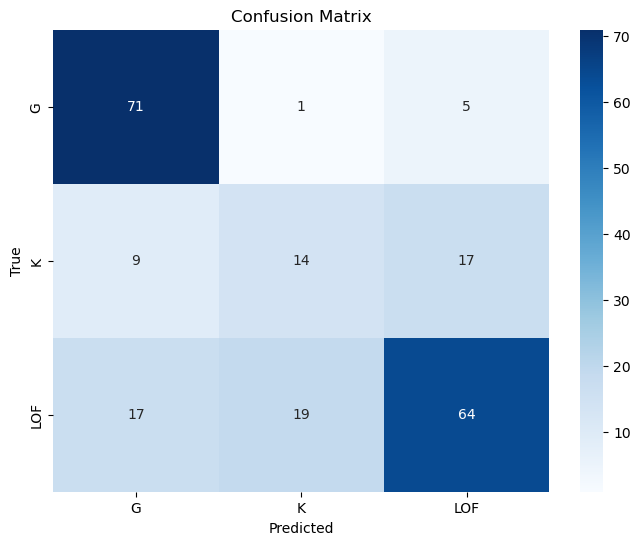

In [10]:
# Compute confusion matrix
cm = confusion_matrix(y_test_knn, y_pred_knn)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm,  cmap='Blues', fmt='g', xticklabels=['G','K','LOF'], yticklabels=['G','K','LOF'], annot = True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

We're gonna see this same confusion matrix quite a few times I feel. It just visually shows how accurate G and LOF classifications are, compared to K being all over the shop

## Decision Tree Classifier

Decision tree classifiers are a type of supervised learning algorithm used for classification tasks. They partition the feature space into regions by making sequential decisions based on feature values. At each node of the tree, the algorithm selects the feature that best separates the data into homogeneous subsets with respect to the target variable. This process continues recursively until a stopping criterion is met, such as reaching a maximum depth or purity level. During prediction, the input features are traversed through the decision tree structure, and the final prediction is made based on the majority class of the instances in the leaf node reached.

In [11]:
from sklearn.tree import DecisionTreeClassifier, plot_tree


# Split data into train and test sets (we're gonna see this line of code a lot as we're using the same data) 
X_train_dtc, X_test_dtc, y_train_dtc, y_test_dtc = train_test_split(X_, y_, test_size=0.2, random_state=42)

# Defining the parameter grid
param_grid = {
    'max_depth': [None, 5, 10], #This determines the amount of levels between the root node, and the leaf nodes. A value too low may lead to underfitting
    #with the model failing to capture important patterns, while too large may lead to overfitting and increased variance
    'min_samples_split': [2, 5, 10], #This value determines the amount of samples required in a node to split it. If it contains less than this value, 
    #it will not be split further and be converted to a leaf node. 
    'min_samples_leaf': [1, 2, 4] #this value determines the min amount of samples for a node to be a leaf node. During tree contruction, if the number of 
    #values in a leaf node is less than this value, the split will be cancelled with the parent becoming a leaf. 
}

# Instantiate DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier()

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to training data
grid_search.fit(X_train_dtc, y_train_dtc)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Get best model
best_dt = grid_search.best_estimator_

# Predict on test set
y_pred_dtc = best_dt.predict(X_test_dtc)

# Print classification report
print("Classification Report:")
print(classification_report(y_test_dtc, y_pred_dtc, target_names=['G','K','LOF']))


Best Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Classification Report:
              precision    recall  f1-score   support

           G       0.71      0.91      0.80        77
           K       0.56      0.47      0.51        40
         LOF       0.79      0.67      0.72       100

    accuracy                           0.72       217
   macro avg       0.69      0.68      0.68       217
weighted avg       0.72      0.72      0.71       217



Interesting. A bit less accurate than KNN, but the same trend with classifying LOF and G pores much better than K pores. See below an interesting aside on how Decision Trees look. Very Tree-like. The Gini Impurity is printed on each node for interest. As the root node is based on Area, we can say that the DT model found this to be the most important feature when it comes to initially seperating out our data. 

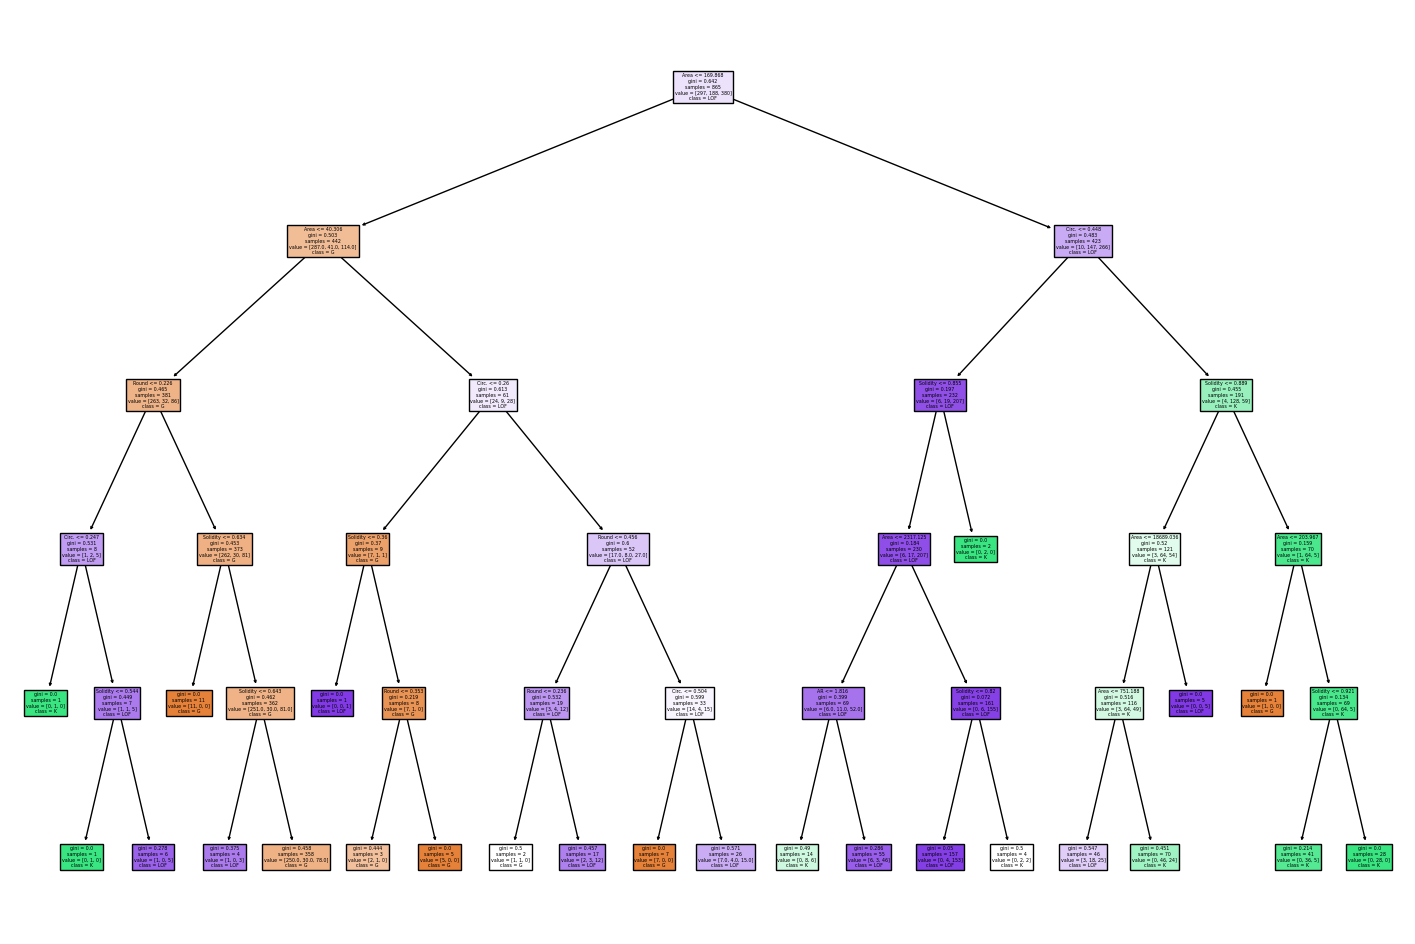

In [12]:
# Plot decision tree
plt.figure(figsize=(18, 12))
plot_tree(best_dt, feature_names=['Area','Circ.','AR','Round','Solidity'], class_names=['G','K','LOF'], filled=True)
plt.show()

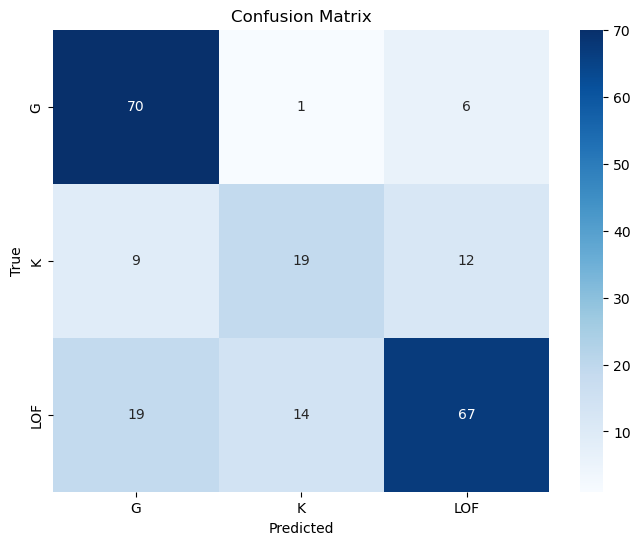

In [13]:
# Compute confusion matrix
cm = confusion_matrix(y_test_dtc, y_pred_dtc)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm,  cmap='Blues', fmt='g', xticklabels=['G','K','LOF'], yticklabels=['G','K','LOF'], annot = True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Naive Bayes Classifier

Naive Bayes classifier is based on Bayes' theorem, which calculates the probability of a class label given the features of an instance. It assumes that the features are conditionally independent given the class label, hence the term "naive." The probability model is built by estimating the conditional probability distributions of features given each class from the training data. 

Given a new instance with feature values, the Naive Bayes classifier calculates the posterior probability of each class label given the features using Bayes' theorem. It selects the class label with the highest posterior probability as the predicted class for the instance.

In our case, it's kind of like the model saying 'If I were a LOF pore, based on the training data, how likely would it be that I have an Area, Circularity, etc of x,y,z?'. And then doing the same for K and G pores and picking the most likely case. The Naive part of this model in assuming the features are independant could be a stretch here, as they are all geometric and could be related somehow. Anyway enough yapping.

Also, important shoutout. We can either use a multinomial, bernoulli, or gaussian naive bayes here. The difference in model depends on how they assume the distributions of the features. 

- Multinomial assume a multinomial distribution (groundbreaking), e.g. frequency of occurences. Useful for text classification (Email Spam/Not Spam)
- Bernoulli assume features are binary variables, and follow a bernoulli distribution.
- Guassian distribution assumes features follow a continuous Guassian distribution. We're gonna use this one. Our features may not be Gaussian (we could check but nah) but theyre definitely continuous

In [14]:
from sklearn.naive_bayes import GaussianNB

X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X_, y_, test_size=0.2, random_state=42)

# Define parameter grid
param_grid = {
    #Gaussian Model has no hyperparameters as it generalizes pretty well 
}

# Instantiate Naive Bayes classifier
nb_classifier = GaussianNB()

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=nb_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to training data
grid_search.fit(X_train_nb, y_train_nb.ravel())

# Get best estimator
best_nb = grid_search.best_estimator_

# Predict on test set
y_pred_nb = best_nb.predict(X_test_nb)

# Print classification report
print("Classification Report:")
print(classification_report(y_test_nb, y_pred_nb, target_names=['G','K','LOF']))


Classification Report:
              precision    recall  f1-score   support

           G       0.65      0.97      0.78        77
           K       0.35      0.55      0.43        40
         LOF       0.95      0.37      0.53       100

    accuracy                           0.62       217
   macro avg       0.65      0.63      0.58       217
weighted avg       0.73      0.62      0.60       217



This is a bit less accurate, dropping into the 60's for overall accuracy. The precision for LOF increased higely here though to 0.95, meaning that when it predictedd a LOF pore, it tended to get it right. Lets take a look at our confusion matrix here to visualise this. Given that the recall for LOF pores is poor here though, I'd expect to see a dollop of blue accross that bottom row. 

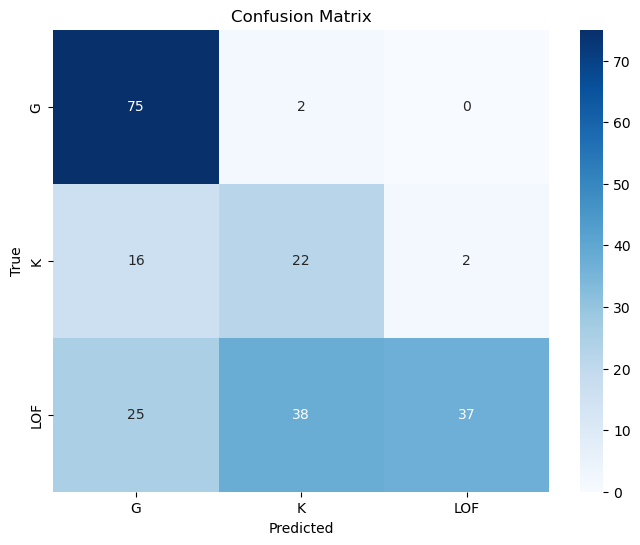

In [15]:
# Compute confusion matrix
cm = confusion_matrix(y_test_nb, y_pred_nb)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm,  cmap='Blues', fmt='g', xticklabels=['G','K','LOF'], yticklabels=['G','K','LOF'], annot = True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Support Vector Machine

Support Vector Machines (SVMs) are powerful supervised learning models primarily used for classification tasks. They operate by finding the optimal hyperplane that best separates data points into different classes in a high-dimensional space. SVM aims to maximize the margin, which is the distance between the hyperplane and the nearest data points from each class, ensuring better generalization to unseen data.

SVMs are called "soft classifiers" because they allow some misclassification of data points to achieve a better overall fit. This is in contrast to "hard classifiers," which strictly enforce all data points to be correctly classified, often leading to overfitting. 

SVM's use things called Kernel functions, which take low dimensional data, transform it to higher dimensional space, and then attempt to find the hyperplane that best seperates the data within that higher dimension. 

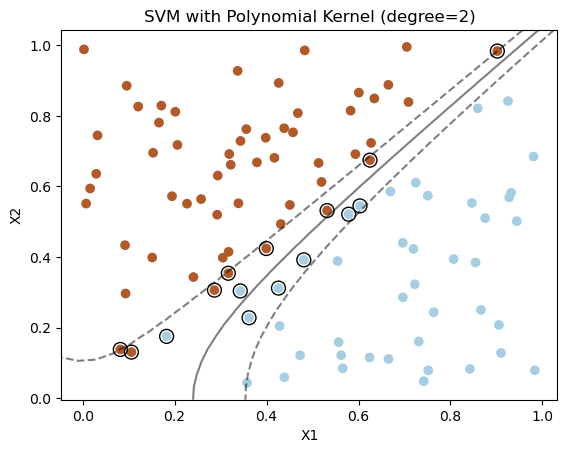

In [16]:
from sklearn import svm

# Generating linearly separable data. This creates a 2D grid, where the class depends on the points Grid position
np.random.seed(123)
X = np.random.rand(100, 2)
y = np.zeros(100)
y[X[:, 1] > X[:, 0]] = 1

# Instantiating and Training SVM with polynomial kernel of degree 2
svm_poly = svm.SVC(kernel='poly', degree=2)
svm_poly.fit(X, y)

# Plotting data points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)

# Getting the current graphs axis limits 
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Creating grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30) #Creating an x-grid
yy = np.linspace(ylim[0], ylim[1], 30) #Creating a y-grid
YY, XX = np.meshgrid(yy, xx) #Meshgrid creates a grid from the above xxx and yy grids of every possible combination
xy = np.vstack([XX.ravel(), YY.ravel()]).T #Here we use ravel to convert these to XX & YY gridpoints to 1D arrays. This is then stacked vertically 
#and Transposed to form an array of coordinate pairs
Z = svm_poly.decision_function(xy).reshape(XX.shape) #The xy array is then fed to the kernel function, evaluated, and this evaluation is reshaped
#into a 30,30 grid

# Plotting decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--']) # Producing a contour plot of the decision function accross
#our grid
ax.scatter(svm_poly.support_vectors_[:, 0], svm_poly.support_vectors_[:, 1], s=100, facecolors='none', edgecolors='k') #encircling our support vectors
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('SVM with Polynomial Kernel (degree=2)')
plt.show()


Here we see an example of the support vector machine in action. We have binary classification using an x,y grid. The class depends on whether your X > Y and all that jazz. We then instantiate an SVM using a Polynomial (D=2) kernel. We can see the decision boundary depicted by the continuous black line. The support vectors of this model are also encircled in black. 

The margin is also depicted in a broken black line. These are the points in each class closest to the decision boundary. Note how the Support Vectors also lie between the margin and the decision boundary. These were used in the calculation of this boundary. We can also see the 'Soft Classification' in action, with the two blue lads (class 1) being behind enemy lines. 

Anyway, enough rabble. Lets get back to business.

In [17]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_, y_, test_size=0.2, random_state=42)

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': [  'poly'],
    'degree': [2, 3, 4],
}

# Instantiate Naive Bayes classifier
svm_classifier = svm.SVC()

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to training data
grid_search.fit(X_train_svm, y_train_svm.ravel())

# Get best estimator
best_svm = grid_search.best_estimator_

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Predict on test set
y_pred_svm = best_svm.predict(X_test_svm)

# Print classification report
print("Classification Report:")
print(classification_report(y_test_svm, y_pred_svm, target_names=['G','K','LOF']))

Best Parameters: {'C': 10, 'degree': 2, 'kernel': 'poly'}
Classification Report:
              precision    recall  f1-score   support

           G       0.46      1.00      0.63        77
           K       0.00      0.00      0.00        40
         LOF       0.86      0.42      0.56       100

    accuracy                           0.55       217
   macro avg       0.44      0.47      0.40       217
weighted avg       0.56      0.55      0.48       217



C:\Users\conor\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\conor\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\conor\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


What the frick, this is not accurate at all, only 0.55 for the best accuracy. Just marginally better than flipping a coin really. 

An important thing to note here. I had attempted to expand the grid of parameters to optimise with to include Radial basis kernels, and linear boundary decision kernels. This led to the cell not completing, which I feel was my own fault. RB Kernels are apparently incredibly resource intensive and I may have put the CPU of my poor laptop through a bit much. The 1000 odd items, with 5 or so features may have been a bit much. For the record I'm using a Ryzen 7 7730U processor, with 8 cores. I never actually tried parralelization, which could have helped by spreading the load out to a few or the processors. We could have also tried shifting this calculation off the CPU and onto the GPU here, but I'm gonna be lazy and consider this outside of the scope of this. Although Scikit learn does have the ability to do this apparently, so maybe I'll come back to this someday. 

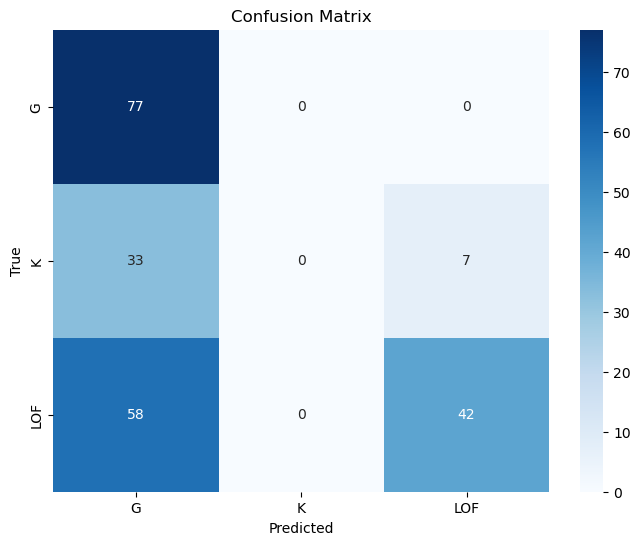

In [18]:
# Compute confusion matrix
cm = confusion_matrix(y_test_svm, y_pred_svm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm,  cmap='Blues', fmt='g', xticklabels=['G','K','LOF'], yticklabels=['G','K','LOF'], annot = True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

This is a strange confusion matrix. This model tended to think everything was a gas pore. Explains the perfect Gas Recall. The precision of the LOF pores again is a strange one. It probably only thought the largest and most drastically out of shape (me) pores were LOF pores. 

## Logistic Regression 

Logistic regression is a statistical method used for binary and multiclassification tasks, where the goal is to predict the probability that an input belongs to one of two classes. It models the relationship between the input features and the probability of belonging to the positive class using the logistic function, also known as the sigmoid function. The logistic function maps any real-valued number into a probability between 0 and 1, making it suitable for binary classification. Logistic regression calculates the weighted sum of the input features along with an intercept term, which represents the log-odds of the probability of the positive class. The log-odds are transformed into probabilities using the logistic function, where higher values represent higher probabilities of belonging to the positive class.

During training, logistic regression adjusts the weights and the intercept term to minimize the difference between the predicted probabilities and the actual class labels in the training data. This optimization is typically done using techniques like gradient descent, which iteratively updates the parameters to minimize a loss function, such as the logistic loss or cross-entropy loss. Once trained, logistic regression can make predictions on new data by calculating the probability using the learned parameters and applying a threshold to determine the predicted class.

While logistic regression is primarily used for binary classification, it can be extended to handle multiclass classification tasks through techniques like one-vs-rest or multinomial 

In [19]:
from sklearn.linear_model import LogisticRegression

# Split the data into training and testing sets
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_, y_, test_size=0.2, random_state=42)

# Define the logistic regression classifier
logistic_regression = LogisticRegression()

# Define the parameter grid to search
param_grid = {
    'penalty': ['l1', 'l2'],           # Penalty term (regularization method): L1 or L2
    'C': [0.1, 1, 10],                 # Inverse of regularization strength
    'solver': ['liblinear', 'saga'],   # Algorithm to use in the optimization problem
    'max_iter': [100, 200, 300]        # Maximum number of iterations taken for the solvers to converge
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV to the training data
grid_search.fit(X_train_lr, y_train_lr.ravel())

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)

# Use the best model to predict
best_model = grid_search.best_estimator_
y_pred_lr = best_model.predict(X_test_lr)

# Display classification report with F1 score, recall, and precision
print("\nClassification Report:")
print(classification_report(y_test_lr, y_pred_lr))


C:\Users\conor\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\conor\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\conor\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\conor\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\conor\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\conor\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

Best Parameters: {'C': 10, 'max_iter': 300, 'penalty': 'l1', 'solver': 'liblinear'}

Classification Report:
              precision    recall  f1-score   support

           G       0.68      0.95      0.79        77
           K       0.50      0.30      0.38        40
         LOF       0.79      0.67      0.72       100

    accuracy                           0.70       217
   macro avg       0.65      0.64      0.63       217
weighted avg       0.70      0.70      0.68       217



Now this model performed very similarly to the KNN at the beginning. Similar accuracy, with a similat behaviour with respect to G and LOF pores. 

In [20]:
# Output learned weights (coefficients) and intercept
print("Learned Weights (Coefficients):")
print(best_model.coef_)
print("\nIntercept:")
print(best_model.intercept_)

# Define sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Output sigmoid function
print("\nSigmoid Function:")
print("sigmoid(z) = 1 / (1 + exp(-z))")

# Calculate z (linear combination of weights and features) for a sample
sample_index = 0
z = np.dot(best_model.coef_, X_test_lr[sample_index]) + best_model.intercept_

# Output sigmoid value for the sample
print("\nSample Features:")
print(X_test_lr[sample_index])
print("\nLinear Combination (z):")
print(z)
print("\nSigmoid Value (Probability):")
print(sigmoid(z))

Learned Weights (Coefficients):
[[-7.02168059e-03  7.14199572e-01 -1.00899626e-01  2.70485462e-02
  -1.14681540e+00]
 [-7.40710545e-05 -5.67116096e+00 -1.33787940e+00 -4.06234588e+00
   1.16797134e+01]
 [ 8.91356756e-05 -2.67585523e+00  2.27730010e-01  1.09615838e+00
  -6.63318666e-01]]

Intercept:
[ 1.28000691 -2.04846585  0.58564678]

Sigmoid Function:
sigmoid(z) = 1 / (1 + exp(-z))

Sample Features:
[6.46534e+02 4.29000e-01 3.31500e+00 3.02000e-01 8.22000e-01]

Linear Combination (z):
[-4.22235257 -0.59045757  0.03605101]

Sigmoid Value (Probability):
[0.01445218 0.35652987 0.50901178]


Above, in order of whats occuring. 
- We first see the weights our optimised model has learned per feature for each class. We also see the intercept per class (bias).
- We then see the feature values for a sample at index 0 in our training data.
- We see the log-likelihood of that item belonging to each class. This was calculated using the z value, which calculates the dot product between the weights times the feature values plus the bias. This is also done per class.
- We then see the probability calculated using the sigmoid function. In this case it is a LOF pore. There is also only a small difference between the sample being calculated as a keyhole pore. The precision of LOF classification in this midel will probably be affected by situations like this. 

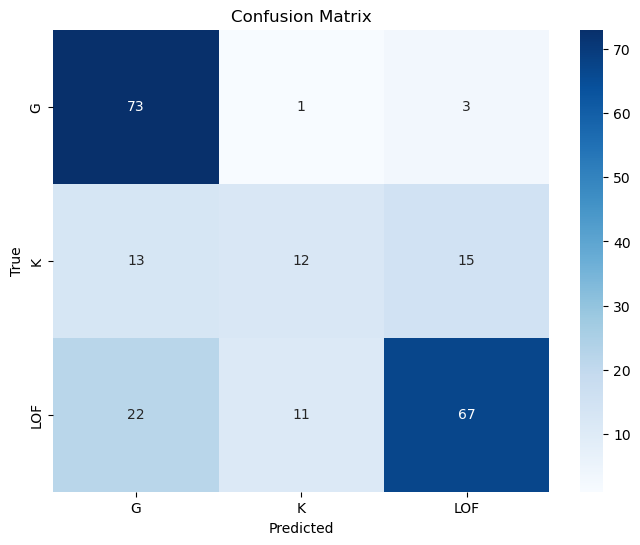

In [21]:
# Compute confusion matrix
cm = confusion_matrix(y_test_lr, y_pred_lr)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm,  cmap='Blues', fmt='g', xticklabels=['G','K','LOF'], yticklabels=['G','K','LOF'], annot = True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

This confusion matrix is similar to the KNN one we encountered initially, with a large amount of correctly classified LOF and G pores. Good bit of clutter elsewhere about the matrix however!

## Gradient Boosted Classification 

This is the one I am most excited to use, as it seems to be very popular in Machine Learning competitions, and I want to be trendy. 


Gradient Boosting for multiclass classification involves sequentially training weak learners, often decision trees, to correct errors made by the ensemble. Each weak learner focuses on predicting the negative gradient of the loss function with respect to the ensemble's predictions. The sequential training process allows Gradient Boosting to learn complex relationships between features and class labels. For multiclass classification, Gradient Boosting typically employs a one-vs-rest strategy or a multinomial loss function to optimize direct multiclass classification. After training, the predictions of multiple weak learners are combined using a weighted sum. The class with the highest sum of predicted probabilities is assigned as the predicted class. Hyperparameters such as learning rate, tree depth, and regularization parameters are tuned to optimize model performance and prevent overfitting

We'll do a little demo first to see what it is and what it do. s.

In [22]:
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree._export import plot_tree

# Generate a small synthetic dataset with 20 datapoints
X, y = make_classification(n_samples=20, n_features=2, n_informative=2, n_redundant=0, n_classes=2, random_state=42)

# Create a DataFrame of the data points
df = pd.DataFrame(X, columns=['Feature 1', 'Feature 2'])
df['Target'] = y

df.sample(10)

,Feature 1,Feature 2,Target
1,0.947029,0.559068,0
13,1.963233,-0.769720,0
10,1.611252,-0.656781,0
19,1.255794,-0.372050,0
17,-1.425716,-1.313734,0
9,-0.015444,1.092585,1
6,-0.707435,0.892172,1
5,1.470444,-0.860551,0
0,-0.282806,-1.408761,0
11,1.454542,0.913547,1


OK so we've a little baby dataset here of 20 points. They are made using the make_classification function. They are essentialy random x and y gridpoints with a class randomly assigned. 

What we are now going to do, is create a classifier, that only has 2 trees, that can only be 2 nodes deep. We'll see if this fella can predict the classes of the above dataset. 

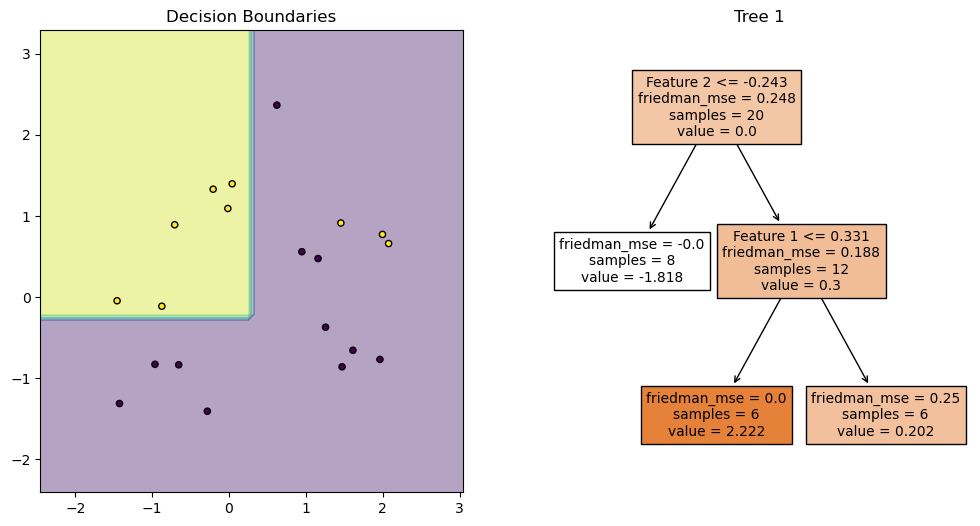

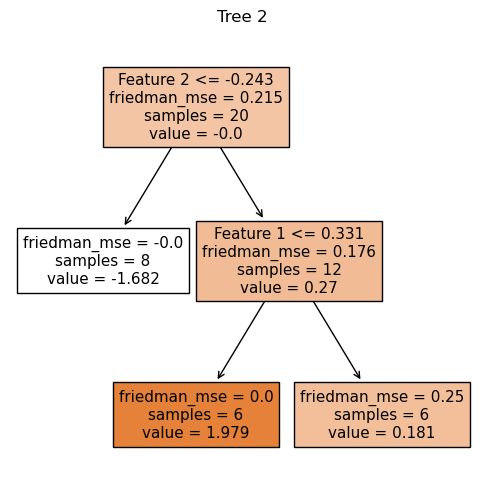

In [23]:
# Initialize and fit Gradient Boosting Classifier with 2 trees
gradient_boosted = GradientBoostingClassifier(n_estimators=2, max_depth=2, random_state=42 )
gradient_boosted.fit(X, y)

# Plot the decision boundaries and the first tree
plt.figure(figsize=(12, 6))

# Plot decision boundaries
plt.subplot(1, 2, 1)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z = gradient_boosted.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
plt.title("Decision Boundaries")

# Plot the first tree
plt.subplot(1, 2, 2)
tree = gradient_boosted.estimators_[0, 0]
plot_tree(tree, filled=True, feature_names=['Feature 1', 'Feature 2'])
plt.title("Tree 1")

plt.show()

# Plot the second tree
plt.figure(figsize=(6, 6))
plot_tree(gradient_boosted.estimators_[1, 0], filled=True, feature_names=['Feature 1', 'Feature 2'])
plt.title("Tree 2")
plt.show()

OK cool, theres a bit to yap about going on here. Firstly we've plotted the feature space (why we picked 2D) of the 20 datapoints. We've then created a grid, evaluated the Gradient boosted classifier at every gridpoint to show it's decision boundary. Theres a misclassification of the 3 lads in yellow, but we'll try not to get too upset. 

On the trees, we can see both (we specified 2 learners) and only 2 nodes per tree. On each node we see the feature and value used to split the data, as well as the Friedman Mean Squared Error. This is an impurity measure, so we'd prefer this to be 0 indicating pure classification. In both trees we have 2 pure leaves, and one impure (the lads from earlier up to no good loitering in zones they shouldn't be in). We can also see the amount of samples in the node. The value on the leaf nodes indicates the class to which the samples in that leaf belong. 

In [24]:
# Split the data into training and testing sets
X_train_gb, X_test_gb, y_train_gb, y_test_gb = train_test_split(X_, y_, test_size=0.2, random_state=42)

# Define the Gradient Boosted Classifier
gradient_boosted = GradientBoostingClassifier()

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],          # Number of boosting stages (trees) to be used
    'learning_rate': [0.01, 0.1, 0.2],       # Learning rate shrinks the contribution of each tree
    'max_depth': [3, 5, 7],                  # Maximum depth of the individual trees
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gradient_boosted, param_grid=param_grid, cv=5)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train_gb, y_train_gb.ravel())

# Get the best parameters and the best score
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best model to predict
best_model = grid_search.best_estimator_
y_pred_gb = best_model.predict(X_test_gb)

# Display classification report with F1 score, recall, and precision
print("\nClassification Report:")
print(classification_report(y_test_gb, y_pred_gb))

# Save the trained model using pickle
with open('gradient_boosted_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

           G       0.76      0.94      0.84        77
           K       0.61      0.47      0.54        40
         LOF       0.81      0.74      0.77       100

    accuracy                           0.76       217
   macro avg       0.73      0.72      0.72       217
weighted avg       0.76      0.76      0.75       217



This is the best performing so far holy fricking smokes. The accuracy of 0.76 is fabulous. No wonder all the cool kids at the competitions use this. Our optimised parameters limit the number of trees to 100, with a learning rate per tree of 0.1, and fairly stumpy trees at a depth of only 3. Now to take a look at the confusion matrix. 

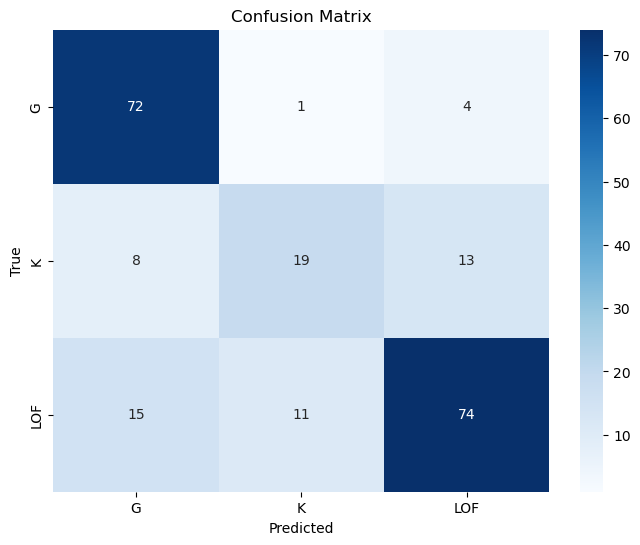

In [25]:
# Compute confusion matrix
cm = confusion_matrix(y_test_gb, y_pred_gb)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm,  cmap='Blues', fmt='g', xticklabels=['G','K','LOF'], yticklabels=['G','K','LOF'], annot = True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Fairly good looking matrix in comparison to our Naive Bayes classifier ain't it? 

## XGBoost Classifier

This fella is meant to be an improved implementation of the Gradient Boosted Classifier. To summarise the differences between the two: 


Gradient Boosting Classifiers and XGBoost are both machine learning algorithms used for supervised learning tasks such as classification and regression. Gradient Boosting Classifiers are based on the gradient boosting framework, combining multiple weak learners (usually decision trees) to form a strong predictive model. XGBoost, on the other hand, is an optimized implementation of gradient boosting, introducing enhancements such as regularization, parallel computing, and tree pruning to improve performance and scalability. XGBoost generally outperforms traditional gradient boosting implementations due to its optimized algorithms and implementation, especially for larger datasets or when maximum performance is required. XGBoost incorporates regularization techniques like L1 and L2 regularization to prevent overfitting and improve generalization, whereas traditional gradient boosting may not include these techniques by defauls.

In [26]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
                           
# Split the data into training and testing sets
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_, y_, test_size=0.2, random_state=42)
y_train_xgb = le.fit_transform(y_train_xgb)
y_test_xgb = le.fit_transform(y_test_xgb)

# Define the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Define the parameter grid to search
param_grid = {
    'n_estimators': [ 100],
    'learning_rate': [0.1],
    'max_depth': [3],
    'min_child_weight': [1, 3, 5], # Minimum sum of instance weight needed in a child node.
    'gamma': [0, 0.1, 0.2], #  Minimum loss reduction required to make a further partition on a leaf node.
    'subsample': [0.6, 0.8, 1.0], # Fraction of samples to be used for training each tree.
    'colsample_bytree': [0.6, 0.8, 1.0], # Fraction of features to be used for training each tree.
    'objective': ['multi:softmax'] # Learning objective or loss function to be optimized, such as 'multi:softmax' for multiclass classification.
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train_xgb, y_train_xgb.ravel())

# Get the best parameters and the best score
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best model to predict
best_model = grid_search.best_estimator_
y_pred_xgb = best_model.predict(X_test_xgb)

# Display classification report with F1 score, recall, and precision
print("\nClassification Report:")
print(classification_report(y_test_xgb, y_pred_xgb))


C:\Users\conor\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\conor\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'multi:softmax', 'subsample': 0.6}

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.86      0.79        77
           1       0.54      0.47      0.51        40
           2       0.71      0.65      0.68       100

    accuracy                           0.69       217
   macro avg       0.66      0.66      0.66       217
weighted avg       0.69      0.69      0.69       217



I am amazed, aghast, apalled, and absolutely astonished. This is not what I expected. If it ain't broke don't fix it i suppose. Lets stick with the Gradient Boosted Classifier as our model. 

Just kidding. We're gonna check out the Multi-Layer perceptron as our final model check. 

## Multi-layer Perceptron

The final check. The Last Dance. One last model before Jerry Strauss breaks up this notebook. 

Multi-layer perceptrons (MLPs) are a type of artificial neural network commonly used for multiclass classification tasks. MLPs consist of an input layer, one or more hidden layers, and an output layer. In multiclass classification, the output layer typically contains multiple neurons, each representing a different class. During training, MLPs learn to map input features to the probability distribution over the possible classes. Neurons in each layer (except the input layer) perform computations on the input data using weighted sums and activation functions. Each connection between neurons has an associated weight parameter that determines the strength of the connection. Activation functions introduce non-linearities into the network, allowing it to model complex decision boundaries between classes. During training, the network learns by adjusting the weights based on the difference between the predicted class probabilities and the true class labels, using optimization algorithms like gradient descent. Backpropagation is used to calculate the gradients of the loss function with respect to the weights, enabling efficient weight updates.

To illustrate the above, see the below image, generated using the Neural Network visualising tool
https://alexlenail.me/NN-SVG/index.html

In [27]:
from IPython.display import display, HTML

# Define the HTML content
html_content = """
<svg xmlns="http://www.w3.org/2000/svg" width="1280" height="551" style="cursor: move;"><g transform="translate(-268.16766165383865,-41.21385639192937) scale(1)"><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,185.5, 606.6666666666666,85.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,185.5, 606.6666666666666,125.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,185.5, 606.6666666666666,165.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,185.5, 606.6666666666666,205.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,185.5, 606.6666666666666,245.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,185.5, 606.6666666666666,285.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,85.5, 786.6666666666666,85.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,85.5, 786.6666666666666,125.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,85.5, 786.6666666666666,165.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,85.5, 786.6666666666666,205.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,85.5, 786.6666666666666,245.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,85.5, 786.6666666666666,285.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,85.5, 786.6666666666666,325.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,85.5, 786.6666666666666,365.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,125.5, 786.6666666666666,85.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,125.5, 786.6666666666666,125.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,125.5, 786.6666666666666,165.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,125.5, 786.6666666666666,205.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,125.5, 786.6666666666666,245.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,125.5, 786.6666666666666,285.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,125.5, 786.6666666666666,325.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,125.5, 786.6666666666666,365.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,165.5, 786.6666666666666,85.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,165.5, 786.6666666666666,125.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,165.5, 786.6666666666666,165.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,165.5, 786.6666666666666,205.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,165.5, 786.6666666666666,245.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,165.5, 786.6666666666666,285.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,165.5, 786.6666666666666,325.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,165.5, 786.6666666666666,365.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,205.5, 786.6666666666666,85.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,205.5, 786.6666666666666,125.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,205.5, 786.6666666666666,165.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,205.5, 786.6666666666666,205.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,205.5, 786.6666666666666,245.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,205.5, 786.6666666666666,285.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,205.5, 786.6666666666666,325.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,205.5, 786.6666666666666,365.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,245.5, 786.6666666666666,85.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,245.5, 786.6666666666666,125.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,245.5, 786.6666666666666,165.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,245.5, 786.6666666666666,205.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,245.5, 786.6666666666666,245.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,245.5, 786.6666666666666,285.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,245.5, 786.6666666666666,325.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,245.5, 786.6666666666666,365.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,285.5, 786.6666666666666,85.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,285.5, 786.6666666666666,125.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,285.5, 786.6666666666666,165.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,285.5, 786.6666666666666,205.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,285.5, 786.6666666666666,245.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,285.5, 786.6666666666666,285.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,285.5, 786.6666666666666,325.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,285.5, 786.6666666666666,365.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,85.5, 966.6666666666666,225.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,125.5, 966.6666666666666,225.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,165.5, 966.6666666666666,225.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,205.5, 966.6666666666666,225.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,245.5, 966.6666666666666,225.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,285.5, 966.6666666666666,225.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,325.5, 966.6666666666666,225.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,365.5, 966.6666666666666,225.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,225.5, 606.6666666666666,85.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,225.5, 606.6666666666666,125.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,225.5, 606.6666666666666,165.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,225.5, 606.6666666666666,205.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,225.5, 606.6666666666666,245.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,225.5, 606.6666666666666,285.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,265.5, 606.6666666666666,85.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,265.5, 606.6666666666666,125.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,265.5, 606.6666666666666,165.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,265.5, 606.6666666666666,205.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,265.5, 606.6666666666666,245.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,265.5, 606.6666666666666,285.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,305.5, 606.6666666666666,85.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,305.5, 606.6666666666666,125.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,305.5, 606.6666666666666,165.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,305.5, 606.6666666666666,205.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,305.5, 606.6666666666666,245.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,305.5, 606.6666666666666,285.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,185.5, 606.6666666666666,325.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,225.5, 606.6666666666666,325.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,265.5, 606.6666666666666,325.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,305.5, 606.6666666666666,325.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,325.5, 786.6666666666666,85.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,325.5, 786.6666666666666,125.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,325.5, 786.6666666666666,165.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,325.5, 786.6666666666666,205.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,325.5, 786.6666666666666,245.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,325.5, 786.6666666666666,285.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,325.5, 786.6666666666666,325.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,325.5, 786.6666666666666,365.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,185.5, 606.6666666666666,365.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,225.5, 606.6666666666666,365.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,265.5, 606.6666666666666,365.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,305.5, 606.6666666666666,365.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,365.5, 786.6666666666666,85.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,365.5, 786.6666666666666,125.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,365.5, 786.6666666666666,165.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,365.5, 786.6666666666666,205.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,365.5, 786.6666666666666,245.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,365.5, 786.6666666666666,285.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,365.5, 786.6666666666666,325.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,365.5, 786.6666666666666,365.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,85.5, 966.6666666666666,265.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,125.5, 966.6666666666666,265.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,165.5, 966.6666666666666,265.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,205.5, 966.6666666666666,265.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,245.5, 966.6666666666666,265.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,285.5, 966.6666666666666,265.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,325.5, 966.6666666666666,265.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,365.5, 966.6666666666666,265.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,85.5, 966.6666666666666,305.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,125.5, 966.6666666666666,305.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,165.5, 966.6666666666666,305.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,205.5, 966.6666666666666,305.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,245.5, 966.6666666666666,305.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,285.5, 966.6666666666666,305.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,325.5, 966.6666666666666,305.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,365.5, 966.6666666666666,305.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,345.5, 606.6666666666666,85.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,345.5, 606.6666666666666,125.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,345.5, 606.6666666666666,165.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,345.5, 606.6666666666666,205.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,345.5, 606.6666666666666,245.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,345.5, 606.6666666666666,285.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,345.5, 606.6666666666666,325.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,345.5, 606.6666666666666,365.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,185.5, 606.6666666666666,405.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,225.5, 606.6666666666666,405.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,265.5, 606.6666666666666,405.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,305.5, 606.6666666666666,405.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,345.5, 606.6666666666666,405.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,405.5, 786.6666666666666,85.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,405.5, 786.6666666666666,125.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,405.5, 786.6666666666666,165.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,405.5, 786.6666666666666,205.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,405.5, 786.6666666666666,245.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,405.5, 786.6666666666666,285.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,405.5, 786.6666666666666,325.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,405.5, 786.6666666666666,365.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,185.5, 606.6666666666666,445.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,225.5, 606.6666666666666,445.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,265.5, 606.6666666666666,445.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,305.5, 606.6666666666666,445.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M426.66666666666663,345.5, 606.6666666666666,445.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,445.5, 786.6666666666666,85.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,445.5, 786.6666666666666,125.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,445.5, 786.6666666666666,165.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,445.5, 786.6666666666666,205.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,445.5, 786.6666666666666,245.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,445.5, 786.6666666666666,285.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,445.5, 786.6666666666666,325.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,445.5, 786.6666666666666,365.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,85.5, 786.6666666666666,405.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,125.5, 786.6666666666666,405.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,165.5, 786.6666666666666,405.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,205.5, 786.6666666666666,405.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,245.5, 786.6666666666666,405.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,285.5, 786.6666666666666,405.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,325.5, 786.6666666666666,405.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,365.5, 786.6666666666666,405.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,405.5, 786.6666666666666,405.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,445.5, 786.6666666666666,405.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,405.5, 966.6666666666666,225.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,405.5, 966.6666666666666,265.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,405.5, 966.6666666666666,305.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,85.5, 786.6666666666666,445.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,125.5, 786.6666666666666,445.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,165.5, 786.6666666666666,445.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,205.5, 786.6666666666666,445.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,245.5, 786.6666666666666,445.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,285.5, 786.6666666666666,445.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,325.5, 786.6666666666666,445.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,365.5, 786.6666666666666,445.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,405.5, 786.6666666666666,445.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M606.6666666666666,445.5, 786.6666666666666,445.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,445.5, 966.6666666666666,225.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,445.5, 966.6666666666666,265.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><path class="link" marker-end="url(#arrow)" d="M786.6666666666666,445.5, 966.6666666666666,305.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none; opacity: 1;"></path><circle r="10" class="node" id="0_0" cx="426.66666666666663" cy="185.5" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51); opacity: 1;"></circle><circle r="10" class="node" id="0_1" cx="426.66666666666663" cy="225.5" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51); opacity: 1;"></circle><circle r="10" class="node" id="0_2" cx="426.66666666666663" cy="265.5" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51); opacity: 1;"></circle><circle r="10" class="node" id="0_3" cx="426.66666666666663" cy="305.5" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51); opacity: 1;"></circle><circle r="10" class="node" id="0_4" cx="426.66666666666663" cy="345.5" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51); opacity: 1;"></circle><circle r="10" class="node" id="1_0" cx="606.6666666666666" cy="85.5" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51); opacity: 1;"></circle><circle r="10" class="node" id="1_1" cx="606.6666666666666" cy="125.5" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51); opacity: 1;"></circle><circle r="10" class="node" id="1_2" cx="606.6666666666666" cy="165.5" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51); opacity: 1;"></circle><circle r="10" class="node" id="1_3" cx="606.6666666666666" cy="205.5" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51); opacity: 1;"></circle><circle r="10" class="node" id="1_4" cx="606.6666666666666" cy="245.5" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51); opacity: 1;"></circle><circle r="10" class="node" id="1_5" cx="606.6666666666666" cy="285.5" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51); opacity: 1;"></circle><circle r="10" class="node" id="1_6" cx="606.6666666666666" cy="325.5" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51); opacity: 1;"></circle><circle r="10" class="node" id="1_7" cx="606.6666666666666" cy="365.5" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51); opacity: 1;"></circle><circle r="10" class="node" id="1_8" cx="606.6666666666666" cy="405.5" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51); opacity: 1;"></circle><circle r="10" class="node" id="1_9" cx="606.6666666666666" cy="445.5" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51); opacity: 1;"></circle><circle r="10" class="node" id="2_0" cx="786.6666666666666" cy="85.5" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51); opacity: 1;"></circle><circle r="10" class="node" id="2_1" cx="786.6666666666666" cy="125.5" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51); opacity: 1;"></circle><circle r="10" class="node" id="2_2" cx="786.6666666666666" cy="165.5" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51); opacity: 1;"></circle><circle r="10" class="node" id="2_3" cx="786.6666666666666" cy="205.5" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51); opacity: 1;"></circle><circle r="10" class="node" id="2_4" cx="786.6666666666666" cy="245.5" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51); opacity: 1;"></circle><circle r="10" class="node" id="2_5" cx="786.6666666666666" cy="285.5" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51); opacity: 1;"></circle><circle r="10" class="node" id="2_6" cx="786.6666666666666" cy="325.5" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51); opacity: 1;"></circle><circle r="10" class="node" id="2_7" cx="786.6666666666666" cy="365.5" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51); opacity: 1;"></circle><circle r="10" class="node" id="2_8" cx="786.6666666666666" cy="405.5" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51); opacity: 1;"></circle><circle r="10" class="node" id="2_9" cx="786.6666666666666" cy="445.5" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51); opacity: 1;"></circle><circle r="10" class="node" id="3_0" cx="966.6666666666666" cy="225.5" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51); opacity: 1;"></circle><text class="text" dy=".35em" x="391.66666666666663" y="485.5" style="font-size: 12px;">Input Layer ∈ ℝ⁵</text><text class="text" dy=".35em" x="571.6666666666666" y="485.5" style="font-size: 12px;">Hidden Layer ∈ ℝ¹⁰</text><text class="text" dy=".35em" x="751.6666666666666" y="485.5" style="font-size: 12px;">Hidden Layer ∈ ℝ¹⁰</text><text class="text" dy=".35em" x="931.6666666666666" y="485.5" style="font-size: 12px;">Output Layer ∈ ℝ³</text><circle r="10" class="node" id="3_1" cx="966.6666666666666" cy="265.5" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51); opacity: 1;"></circle><circle r="10" class="node" id="3_2" cx="966.6666666666666" cy="305.5" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51); opacity: 1;"></circle></g><defs><marker id="arrow" viewBox="0 -5 10 10" markerWidth="7" markerHeight="7" orient="auto" refX="40"><path d="M0,-5L10,0L0,5" style="stroke: rgb(80, 80, 80); fill: rgb(80, 80, 80);"></path></marker></defs></svg>"""

# Display the HTML content
display(HTML(html_content))


So, what we have here is an MLP, with 2 hidden layers, an input layer and output layer. This input layer is 5 neurons, as our training data contains 5 features, and the output is 3 neurons, as we are trying to predict G, K and LOF pores. Each output neuron represents the probability of an item belonging to that class. 

Initially, weights are randomly assigned values. Let's just take the first Hidden Layer for example. This takes an input layer of 5 neurons that feed into each hidden layer neuron. We'll call this input vector$X_{(5,1)}$. Now this hidden layer, has one bias value per neuron. We'll therefore shove all this into our bias vector $B^{(1)}_{(10,1)}$, where the superscript denotes it corresponds to the first hidden layer, and subscript corresponds to the 10 neurons. For the weights, each neuron in that initial layer has 5 weights per input neuron, therefore we have a two dimensional matrix respresenting that layers weights $W^{(1)}_{(10,5)}$. The output is therefore simply a linear transformation of the input vector $Y^{(1)}_{(10,1)}$: 

$Y = B + W.X$

Where the dot represents matrix multiplication. This output is then mapped through an Activation function. See below:

$A^{(1)} = f(Y^{(1)})$

This activation function is usually either ReLU (Rectified Linear Unit), tanh (hyperbolic tangent), or logistic sigmoid functions. These functions, introduce non-linearity into the data, allwoing the network to capture more sophisticated relationships within the data. They are also differentiable, enabling the calculation of gradient descent during backpropogation. 

Now anyways, enough babble, lets get this show on the road.

In [28]:
from sklearn.neural_network import MLPClassifier
                           
# Split the data into training and testing sets
X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = train_test_split(X_, y_, test_size=0.2, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(100,), (50,50), (50,)], #Here we're trying different hidden layer sizes. 100 neurons, 50 and 50, and 50 alone
    'activation': ['relu', 'tanh', 'logistic'], #Our different activation functions per neuron
    'solver': ['adam', 'sgd'], #these represent our optimisation algorithm for the weights. Adam represent stochastic gradient based optimiser, while 
    #sgd represents stochastic gradient descent
    'max_iter': [500, 1000] #this represents the number of optimization cycles. This means the updating of the weights based on the gradient of the loss
    ##function
}

# Create an MLP classifier
mlp = MLPClassifier()

# Create a GridSearchCV object
grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1) #Here we set n_jobs = -1 to use all of our CPU cores. Why the heck not?

# Fit the GridSearchCV to the training data
grid_search.fit(X_train_mlp, y_train_mlp.ravel())

# Get the best parameters and the best score
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best model to predict
best_model = grid_search.best_estimator_
y_pred_mlp = best_model.predict(X_test_mlp)

# Display classification report with F1 score, recall, and precision
print("\nClassification Report:")
print(classification_report(y_test_mlp, y_pred_mlp))


Best Parameters: {'activation': 'logistic', 'hidden_layer_sizes': (50,), 'max_iter': 500, 'solver': 'sgd'}

Classification Report:
              precision    recall  f1-score   support

           G       0.77      0.90      0.83        77
           K       0.00      0.00      0.00        40
         LOF       0.67      0.85      0.75       100

    accuracy                           0.71       217
   macro avg       0.48      0.58      0.53       217
weighted avg       0.58      0.71      0.64       217



C:\Users\conor\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\conor\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\conor\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


This was fairly accurate. Probably the next best of Gradient Boosted decision trees. Our optimal solution was 2 hidden layers, adam optimisation algorithm, 1000 iterations for adam (good man yourself adam), and a hyperbolic tangent activation function.

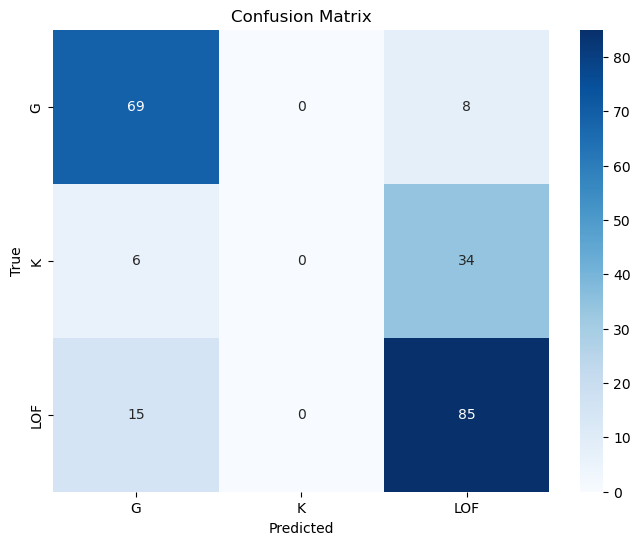

In [29]:
# Compute confusion matrix
cm = confusion_matrix(y_test_mlp, y_pred_mlp)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm,  cmap='Blues', fmt='g', xticklabels=['G','K','LOF'], yticklabels=['G','K','LOF'], annot = True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

MLP really hates Keyhole pores doesn't it?

I'm beginning to wonder if the class imbalance at the start with our training dataset may have affected things, or whether it's purely the fact these pores geometrically really look like an inbetween case of the other two classes. 

# Further investigation of Gradient Boosted Classifier

We now know this model is our best shot. We're going to investigate one further aspect of it's performance. It's ROC (Reciever Operating Characteristic) graph, and it's AUC (Area under Curve) value. 

ROC (Receiver Operating Characteristic) curves are graphical plots that illustrate the performance of binary classification models across different thresholds for predicting the positive class. In our case, even though it is multiclass, it can be broken down into a binary one vs all approach. They depict the trade-off between the true positive rate (Recall) and the false positive rate (1 - specificity) at various classification thresholds. Specificty is essentially Recall but for the negative class.

ROC curves help visualize the performance of a model in distinguishing between positive and negative instances, regardless of the specific threshold chosen. AUC (Area Under the ROC Curve) is a scalar value that quantifies the overall performance of a binary classification model. It represents the probability that the model will rank a randomly chosen positive instance higher than a randomly chosen negative instance. AUC values range from 0 to 1, where a higher AUC indicates better discriminative ability of the model. AUC is a robust metric for evaluating model performance because it considers the entire range of threshold values and is insensitive to class imbalance.

C:\Users\conor\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


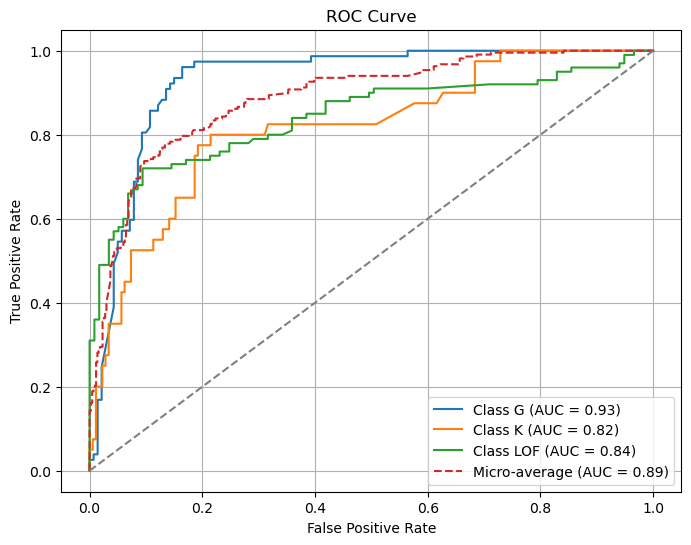

AUC for Class G: 0.93
AUC for Class K: 0.82
AUC for Class LOF: 0.84
Micro-average AUC: 0.89


In [30]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Load the saved Gradient Boosted Model
with open('gradient_boosted_model.pkl', 'rb') as file:
    model = pickle.load(file) 


# Split the data into training and testing sets
X_train_roc, X_test_roc, y_train_roc, y_test_roc = train_test_split(Train_features, Train_labels, test_size=0.2, random_state=42)

# Predict probabilities for each class
probs = model.predict_proba(X_test_roc) #This produces an array of format: [gas_prob,keyhole_prob,lof_prob]

# Binarize the true labels for multiclass ROC curve
y_test_bin = label_binarize(y_test_roc, classes=model.classes_) #array of format [0/1,0/1,0/1] 

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict() 
for i in range(len(model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i]) #ROC function takes the true class labels, and the probabilities and computes the ROC
    #which it returns as a tuple, which we unpack instantly here
    roc_auc[i] = auc(fpr[i], tpr[i]) # The AUC function computes the AUC function directly from the output of the ROC function 

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(model.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {model.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle='--')

# Plot random guessing line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Set plot properties
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print AUC values
for i in range(len(model.classes_)):
    print(f'AUC for Class {model.classes_[i]}: {roc_auc[i]:.2f}')
print(f'Micro-average AUC: {roc_auc_micro:.2f}')


These AUC scores for each class in the Gradient Boosted Classifier are actually quite good. They're all quite close to 1, meaning our model does a good job at distinguishing between true and false instances of each class in the data, regardless of the probability threshold. 

# Pore Type Evaluation 

So we finally made it. We evaluated 7 classifiers, explained how they work, and chose the most accurate one. The whole reasoning behind this was to pick a model to classify a larger unlabelled dataset, and examine how the Pore Types were distributed accross Gas Flow. 

This is to complement our Clustering study, where we saw Irregular (mainly LOF pores) become proportionately more common as Gas Flow decreased. Now lets see if thats the case. 

In [31]:
allpores.shape

(134987, 6)

In [32]:
allpores.sample(5)

,Area,Circ.,AR,Round,Solidity,Gas Flow
75064,1.639,1.000,1.000,1.000,1.000,Control
32195,1.639,1.000,1.000,1.000,1.000,Control
108683,14.755,0.521,2.342,0.427,0.643,Control
17752,37.229,0.902,1.543,0.648,0.902,Low
38657,1.639,1.000,1.000,1.000,1.000,Control


In [33]:
#Select only numeric data 
X_Test = allpores.iloc[:,:-1]

# Load the saved Gradient Boosted Model
with open('gradient_boosted_model.pkl', 'rb') as file:
    model = pickle.load(file) 

# Use the model to predict
Y_Pred = model.predict(X_Test)

allpores['Pore Type'] = Y_Pred

C:\Users\conor\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [34]:
allpores.sample(5)

,Area,Circ.,AR,Round,Solidity,Gas Flow,Pore Type
112110,1.639,1.000,1.000,1.000,1.000,Control,G
83851,29.510,0.755,2.605,0.384,0.818,Control,G
76322,4.918,1.000,1.464,0.683,0.857,Control,G
21545,1.612,1.000,1.000,1.000,1.000,Low,G
91236,4.918,1.000,1.464,0.683,0.857,Control,G


In [35]:
def GasFlowRate_Pore_Proportion(GFRate, Pore):
    df = allpores[allpores['Gas Flow'] == GFRate]
    return round(((len(df[df['Pore Type'] == Pore]))/(len(df))),3)

In [36]:
for i in ['Low', 'Control','High']:
    print('\n')
    for j in ['LOF', 'K','G']:
        print(f'The proportion of {j} type porosity in the {i} Gas Flow rate is {GasFlowRate_Pore_Proportion(i,j)}')



The proportion of LOF type porosity in the Low Gas Flow rate is 0.295
The proportion of K type porosity in the Low Gas Flow rate is 0.076
The proportion of G type porosity in the Low Gas Flow rate is 0.629


The proportion of LOF type porosity in the Control Gas Flow rate is 0.047
The proportion of K type porosity in the Control Gas Flow rate is 0.01
The proportion of G type porosity in the Control Gas Flow rate is 0.943


The proportion of LOF type porosity in the High Gas Flow rate is 0.154
The proportion of K type porosity in the High Gas Flow rate is 0.065
The proportion of G type porosity in the High Gas Flow rate is 0.78


Well, that certainly is a result! We can see the highest proportion of LOF and K pores appeared in the Low Gas Flow Rate, as expected, but there is something amiss about the Control and High gas flow rate Gas Pore proportions. We should be seeing the highest Gas Pore proportion in the High Gas Flow rate. We know this model has a Recall of 0.94 for gas pores, so it's predicting most of them correctly. This could be a proportion issue. Maybe...

In [37]:
print(len(allpores[allpores['Gas Flow'] == 'Control']),len(allpores[allpores['Gas Flow'] == 'High']))

97299 9735


There are almost 10 times as many samples in the Control Flow Rate as the High Flow rate. This could potentially have an impact on the proportion of pores that were classified as Gas, being slightly off in the High Flow Rate.

In [38]:
def GasFlowRate_(Pore):
    return round(np.mean(allpores[allpores['Pore Type'] == Pore]['Area']),3), round(np.mean(allpores[allpores['Pore Type'] == Pore]['Circ.']),3)

In [39]:
for i in ['LOF','K','G']:
    temp1,temp2 = GasFlowRate_(i)
    print(f'{i} Pores had an average area of {temp1} with an average Circularity of {temp2}')

LOF Pores had an average area of 1059.507 with an average Circularity of 0.617
K Pores had an average area of 955.465 with an average Circularity of 0.618
G Pores had an average area of 8.679 with an average Circularity of 0.915


Just a sanity check of the results, The area decreasing from LOF to G, with the Circularity increasing simultaneously as expected!